In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path ='/content/drive/MyDrive/Cloud_Security_Project/Noise_predictor_data/'

In [ ]:
train_dir = base_path+"train/"
test_dir =  base_path+"test/"

In [ ]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
import os
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AveragePooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['adversarial' 'normal']


Image shape: (512, 512, 3)


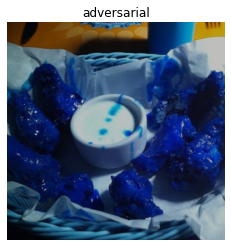

In [ ]:

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


# View a random image from the training dataset

img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

In [ ]:


# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

print('image processing  done')

Found 4000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
image processing  done


# detector one
* using in our paper architecture

In [ ]:
detector1 = Sequential([
  Conv2D(10, 3, activation='sigmoid', input_shape=(224, 224, 3)),
  AveragePooling2D(),
  Conv2D(10, 3, activation='sigmoid'),
  Conv2D(10, 3, activation='sigmoid'),
  UpSampling2D(),
  Conv2D(10, 3, activation='sigmoid'),
  Conv2D(10, 3, activation='sigmoid'),
  Flatten(),
  Dense(2, activation='softmax') 
])

detector1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
detector1.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
125/125 [==============================] - 724s 5s/step - loss: 15.8631 - accuracy: 0.4965 - val_loss: 1.0435 - val_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 504s 4s/step - loss: 0.7639 - accuracy: 0.5030 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 504s 4s/step - loss: 0.7369 - accuracy: 0.5025 - val_loss: 0.7459 - val_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 500s 4s/step - loss: 0.7169 - accuracy: 0.4930 - val_loss: 0.7763 - val_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 499s 4s/step - loss: 0.7158 - accuracy: 0.4900 - val_loss: 0.7097 - val_accuracy: 0.5000


In [ ]:
detector1.evaluate(test_data)

 5/13 [==========>...................] - ETA: 16s - loss: 0.7097 - accuracy: 0.5000

# detector two
* using model scratch
* What is the benefit of using two consecutive convolutional layers then a pool layer instead of a conv pool?
*Pooling decreases the dimensions of your data exponentially. And so even if you have an image of size 256 x 256, you only get maybe 5 pools before you lose too much information (and therefore 5 convolutions). As a result, we would typically like to have multiple conv layers before a pool, so that we can build up better representations of the data without quickly losing all of your spatial information.

In fact, we often don't even use two convolutions per pool, in many of the modern large image classifican networks, like VGG, Inception and ResNet, you can often see 5–30 conv layers at a time before pooling!

In [ ]:
detector_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(2, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])


In [ ]:
detector2.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])detector.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
detector2.evaluate(test_data)

# detector three
* Use Resnet50

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
detector3 = create_model(resnet_url, num_classes=10)

# Compile
detector3.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
detector3.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
        )

Epoch 1/5
235/235 [==============================] - 2271s 10s/step - loss: 0.9108 - accuracy: 0.7005 - val_loss: 0.5304 - val_accuracy: 0.8268
Epoch 2/5
235/235 [==============================] - 1770s 8s/step - loss: 0.5354 - accuracy: 0.8248 - val_loss: 0.4798 - val_accuracy: 0.8400
Epoch 3/5
235/235 [==============================] - 1769s 8s/step - loss: 0.4308 - accuracy: 0.8584 - val_loss: 0.4604 - val_accuracy: 0.8464
Epoch 4/5
 62/235 [======>.......................] - ETA: 16:29 - loss: 0.3460 - accuracy: 0.8947

In [ ]:
detector3.evaluate(test_data)